In [1]:
import gzip
import pandas as pd
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
import matplotlib.pyplot as plt
import warnings
from collections import OrderedDict
warnings.filterwarnings("ignore")

In [2]:
def readAppr(path):
    f = gzip.open(path, 'rt')
    for l in f:
        u,i,ts = l.strip().split(' ')
        yield u,i,ts

def readOwners(path):
    f = gzip.open(path, 'rt')
    for l in f:
        u,i = l.strip().split(' ')
        yield u,i


## Exploratory Data Analysis

In [25]:
## RAW_interactions parsing

In [28]:
interactions = []
#data = pd.read_csv("interactions_train.csv")
data_raw_interactions = pd.read_csv("RAW_interactions.csv")
#data_raw_interactions = data_raw_interactions.sample(50000)

In [29]:
#size of dataset
data_raw_interactions.shape

(1132367, 5)

In [30]:
data_raw_interactions.iloc[0,:]

user_id                                                  38094
recipe_id                                                40893
date                                                2003-02-17
rating                                                       4
review       Great with a salad. Cooked on top of stove for...
Name: 0, dtype: object

In [31]:
recipeperUser = defaultdict(list)
userperRecipe  = defaultdict(list)
ratingsperUser = defaultdict(list)
ratingsperDate = defaultdict(list)
ratingsperRecipe = defaultdict(list)
occurenceperRating = defaultdict(list)
all_recipes = set()
all_users = set()
for index, row in data_raw_interactions.iterrows():
    u,i,r =  row['user_id'], row['recipe_id'],row['rating']
    recipeperUser[u].append(i)
    userperRecipe[i].append(u)
    ratingsperRecipe[i].append(r)
    ratingsperUser[u].append((i,r))
    all_recipes.add(row['recipe_id'])
    all_users.add(row['user_id'])
    ratingsperDate[row['date']].append(r)
    if r in occurenceperRating.keys():
        occurenceperRating[r] +=1
    else:
        occurenceperRating[r] = 0

In [7]:
x = len(recipeperUser) #no of users
y = len(userperRecipe) #no of recipes
z = len(ratingsperDate) # number of dates
x,y,z

(226570, 231637, 6396)

In [15]:
#print(max(ratingsperDate, key = ratingsperDate.get))

In [16]:
number_of_ratingsperDate = defaultdict(list)

for x in ratingsperDate.keys():
    number_of_ratingsperDate[x] = len(ratingsperDate[x])

In [21]:
date_with_max_number_of_ratings = max(number_of_ratingsperDate, key = number_of_ratingsperDate.get)
date_with_min_number_of_ratings = min(number_of_ratingsperDate, key = number_of_ratingsperDate.get)

In [22]:
print('Date with max # of ratings',date_with_max_number_of_ratings, number_of_ratingsperDate[date_with_max_number_of_ratings])
print('Date with min # of ratings',date_with_min_number_of_ratings, number_of_ratingsperDate[date_with_min_number_of_ratings])

Date with max # of ratings 2008-01-27 723
Date with min # of ratings 2000-12-19 1


2000-01-25
2018-12-20

3 32859
11 71972
2 20839
10 107024
5 66489
15 23289
6 89500
7 140895
8 166849
9 158973
18 20560
4 45841
12 56290
14 30392
13 49396
16 18110
17 26987
1 2863
0 104
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']


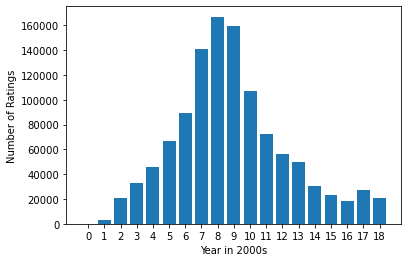

In [64]:
dates = list(ratingsperDate.keys())

values = list(ratingsperDate.values())
 
#################################################
print(min(number_of_ratingsperDate.keys()))
print(max(number_of_ratingsperDate.keys()))
print("")

binned_of_ratingsperDate = defaultdict(list)
for x in number_of_ratingsperDate.keys():
    year = x.split("-", 1)[0]
    year = int(year) - 2000
    if year in binned_of_ratingsperDate.keys(): 
        binned_of_ratingsperDate[year] += number_of_ratingsperDate[x]
    else:
        binned_of_ratingsperDate[year] = 0
    

for x in binned_of_ratingsperDate.keys():
    print(x, binned_of_ratingsperDate[x])
binned_of_ratingsperDate = OrderedDict(sorted(binned_of_ratingsperDate.items()))
################################################
values_length = [binned_of_ratingsperDate[x] for x in binned_of_ratingsperDate.keys()]
plot_x_axis = [str(x) for x in binned_of_ratingsperDate.keys()]
print (plot_x_axis)
plt.bar(plot_x_axis, values_length)
plt.xlabel("Year in 2000s")
plt.ylabel("Number of Ratings")

plt.show()

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18']


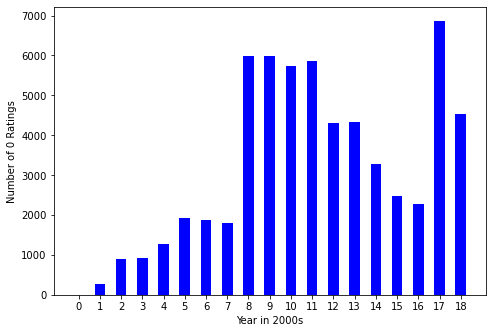

In [133]:
binned_of_ratingsperDate_per_rating = defaultdict(list)

for x in ratingsperDate.keys():
    one = ratingsperDate[x].count(1)
    two = ratingsperDate[x].count(2)
    three = ratingsperDate[x].count(3)
    four = ratingsperDate[x].count(4)
    five = ratingsperDate[x].count(5)
    zero = ratingsperDate[x].count(0)
    year = x.split("-", 1)[0]
    year = int(year) - 2000
    if year in binned_of_ratingsperDate_per_rating.keys():
            binned_of_ratingsperDate_per_rating[year][0]+=zero
            binned_of_ratingsperDate_per_rating[year][1]+=one
            binned_of_ratingsperDate_per_rating[year][2]+=two
            binned_of_ratingsperDate_per_rating[year][3]+=three
            binned_of_ratingsperDate_per_rating[year][4]+=four
            binned_of_ratingsperDate_per_rating[year][5]+=five
            #print(binned_of_ratingsperDate_per_rating[year][0])
    else:
        binned_of_ratingsperDate_per_rating[year] = [0,0,0,0,0,0]
        
        
binned_of_ratingsperDate_per_rating = OrderedDict(sorted(binned_of_ratingsperDate_per_rating.items()))
#################################################################

zeros = [binned_of_ratingsperDate_per_rating[x][0] for x in binned_of_ratingsperDate_per_rating.keys()]
ones = [binned_of_ratingsperDate_per_rating[x][1] for x in binned_of_ratingsperDate_per_rating.keys()]
twos = [binned_of_ratingsperDate_per_rating[x][2] for x in binned_of_ratingsperDate_per_rating.keys()]
threes = [binned_of_ratingsperDate_per_rating[x][3] for x in binned_of_ratingsperDate_per_rating.keys()]
fours = [binned_of_ratingsperDate_per_rating[x][4] for x in binned_of_ratingsperDate_per_rating.keys()]
fives = [binned_of_ratingsperDate_per_rating[x][5] for x in binned_of_ratingsperDate_per_rating.keys()]
plot_x_axis = [str(x) for x in binned_of_ratingsperDate.keys()]
print (plot_x_axis)
fig0 = plt.figure()
ax0 = fig0.add_axes([0,0,1,1])
ax0.bar(plot_x_axis, zeros, color = 'b', width = 0.5, label='zeros')
plt.xlabel("Year in 2000s")
plt.ylabel("Number of 0 Ratings")

plt.show()


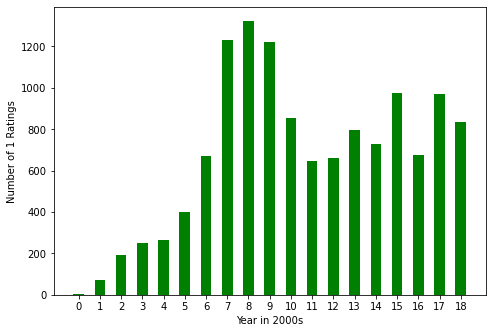

In [134]:
fig1 = plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
ax1.bar([str(int(yr)) for yr in plot_x_axis], ones, color = 'g', width = 0.5, label='ones')
plt.xlabel("Year in 2000s")
plt.ylabel("Number of 1 Ratings")
plt.show()

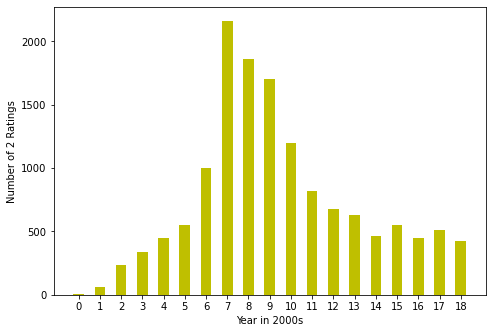

In [135]:
fig2 = plt.figure()
ax2 = fig2.add_axes([0,0,1,1])
ax2.bar([str(int(yr)) for yr in plot_x_axis], twos, color = 'y', width = 0.5, label='twos')
plt.xlabel("Year in 2000s")
plt.ylabel("Number of 2 Ratings")
plt.show()

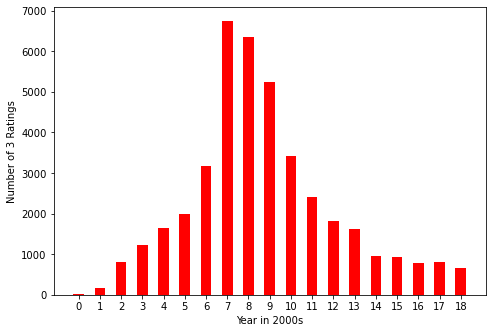

In [136]:
fig3 = plt.figure()
ax3 = fig3.add_axes([0,0,1,1])
ax3.bar([str(int(yr)) for yr in plot_x_axis], threes, color = 'r', width = 0.5, label='threes')
plt.xlabel("Year in 2000s")
plt.ylabel("Number of 3 Ratings")
plt.show()

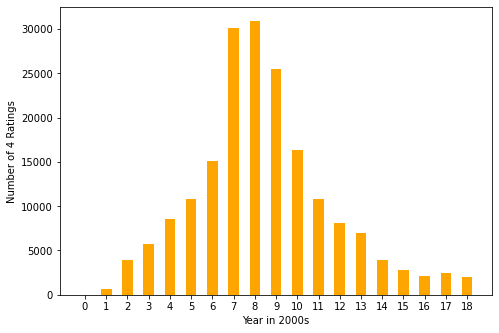

In [137]:
fig4 = plt.figure()
ax4 = fig4.add_axes([0,0,1,1])
ax4.bar([str(int(yr)) for yr in plot_x_axis], fours, color = 'orange', width = 0.5, label='fours')
plt.xlabel("Year in 2000s")
plt.ylabel("Number of 4 Ratings")
plt.show()

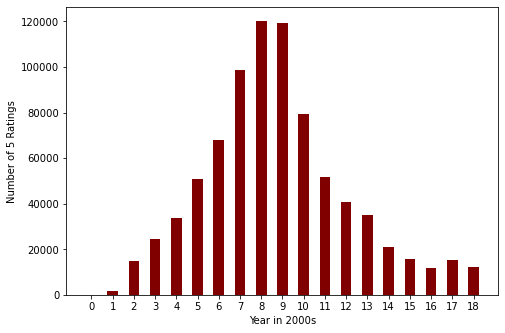

In [138]:
fig5 = plt.figure()
ax5 = fig5.add_axes([0,0,1,1])
ax5.bar([str(int(yr)) for yr in plot_x_axis], fives, color = 'maroon', width = 0.5, label='fives')
plt.xlabel("Year in 2000s")
plt.ylabel("Number of 5 Ratings")
plt.show()

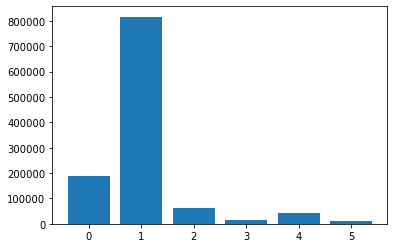

In [23]:
rating_keys = list(occurenceperRating.keys())

rating_occurences = list(occurenceperRating.values())
plt.bar(range(len(occurenceperRating)), rating_occurences)
plt.show()

In [26]:
## RAW_recipes parsing

In [3]:
data_raw_recipes = pd.read_csv("RAW_recipes.csv")

In [4]:
data_raw_recipes.shape

(231637, 12)

In [5]:
#data_raw_recipes.head

In [6]:
data_raw_recipes.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')

In [7]:
data_raw_recipes.iloc[0,:]

name                     arriba   baked winter squash mexican style
id                                                           137739
minutes                                                          55
contributor_id                                                47892
submitted                                                2005-09-16
tags              ['60-minutes-or-less', 'time-to-make', 'course...
nutrition                     [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]
n_steps                                                          11
steps             ['make a choice and proceed with recipe', 'dep...
description       autumn is my favorite time of year to cook! th...
ingredients       ['winter squash', 'mexican seasoning', 'mixed ...
n_ingredients                                                     7
Name: 0, dtype: object

In [19]:
features_per_recipe = defaultdict(list)


#all_users = set()
for index, row in data_raw_recipes.iterrows():
    name,recipe_id,mins,cont_id,sub,tag,nutri,n_steps,steps,descrip,ingred,n_ingred =  row['name'], row['id'],row['minutes'],row['contributor_id'], row['submitted'], row['tags'], row['nutrition'],row['n_steps'],row['steps'], row['description'],row['ingredients'], row['n_ingredients']
    features_per_recipe[recipe_id] = [name,mins,cont_id,sub,tag,nutri,n_steps,steps,descrip,ingred,n_ingred]
    

In [9]:
print(features_per_recipe[137739])

['arriba   baked winter squash mexican style', 55, 47892, '2005-09-16', "['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'side-dishes', 'vegetables', 'mexican', 'easy', 'fall', 'holiday-event', 'vegetarian', 'winter', 'dietary', 'christmas', 'seasonal', 'squash']", '[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]', 11, "['make a choice and proceed with recipe', 'depending on size of squash , cut into half or fourths', 'remove seeds', 'for spicy squash , drizzle olive oil or melted butter over each cut squash piece', 'season with mexican seasoning mix ii', 'for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece', 'season with sweet mexican spice mix', 'bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin', 'be careful not to burn the squash especially if you opt to use sugar or butter', 'if you feel more comfortable 

In [23]:
all_tags = set()
for x in features_per_recipe.keys():
    tag = features_per_recipe[x][4]
    tag = tag.replace('[', '')
    tag = tag.replace(']', '')
    tag = tag.replace('\'', '')
    tag = tag.split(",")
    for y in tag:
        all_tags.add(y)
    #print(tag)

In [24]:
len(all_tags)

572

In [34]:
ratingsperNSteps = defaultdict(list)
for x in ratingsperRecipe:
    for y in ratingsperRecipe[x]:
        ratingsperNSteps[features_per_recipe[x][6]].append(y)


In [46]:
avg_ratingsperNSteps = defaultdict(list)
ratingsperNSteps = OrderedDict(sorted(ratingsperNSteps.items()))
for x in ratingsperNSteps:
    avg_ratingsperNSteps[x] = [sum(ratingsperNSteps[x])/len(ratingsperNSteps[x]),len(ratingsperNSteps[x])]
    print(x,avg_ratingsperNSteps[x][0],avg_ratingsperNSteps[x][1])


0 4.5 2
1 4.468806461898183 9409
2 4.483566239942669 30699
3 4.452875561886088 54059
4 4.444663950842678 73397
5 4.412922109599436 92245
6 4.4190022897939185 100009
7 4.417713073052294 107909
8 4.401365141582753 103579
9 4.406912504491556 89056
10 4.402770533364063 82439
11 4.413317862802807 70672
12 4.406247042120208 52825
13 4.413934180852975 50107
14 4.417376190236284 39698
15 4.393035131975635 32506
16 4.384012721560718 25783
17 4.380899475602169 22502
18 4.357426011403747 18415
19 4.3601200865740415 14323
20 4.391911208273775 11893
21 4.3907522759942506 8348
22 4.396086569819152 6746
23 4.385754451733833 5335
24 4.345753424657534 5475
25 4.296045197740113 3540
26 4.3455642121135964 3979
27 4.34287594603488 3039
28 4.484825201690358 2603
29 4.3816936488169365 1606
30 4.283418553688824 1369
31 4.258741258741258 1001
32 4.329373650107992 926
33 4.330827067669173 798
34 4.33442088091354 613
35 4.461971830985916 710
36 4.355432780847146 543
37 4.26647564469914 349
38 3.9401041666666665

In [42]:
len(avg_ratingsperNSteps)

94

In [7]:
data_pp_recipes = pd.read_csv("PP_recipes.csv")

In [8]:
data_pp_recipes.shape

(178265, 8)

### End of code 

In [ ]:
imgCountAll = defaultdict(int)
totalliked = 0

for user,img,_ in interactions:
    imgCountAll[img] += 1
    totalliked+= 1

mostPopular = [(imgCountAll[x], x) for x in imgCountAll]
mostPopular.sort()
mostPopular.reverse()
print(totalliked)


In [ ]:
return2 = set()
count = 0
threshold = 0.75
for imgCount, img in mostPopular:
    count += imgCount
    return2.add(img)
    if count > totalliked*threshold:
        break

In [ ]:
def Jaccard(s1, s2):
  if not isinstance(s1,set):
    s1 = set(s1)
  if not isinstance(s2,set):
    s2 = set(s2)
  numer = len(s1.intersection(s2))
  denom = len(s1.union(s2))
  if denom == 0:
      return 0
  return numer / denom

def predictRead(user, img):
  Jsimilarities = []
  for d in imgsperUser[user]:
    #d is img user has liked in training
    if d == img: continue
    Jsimilarities.append(Jaccard(userperImgs[img],userperImgs[d]))
  if Jsimilarities and max(Jsimilarities)> 0.003 or img in return2:
    return 1
  return 0
  # mx = 0
  # if Jsimilarities:
  #     mx = max(Jsimilarities)
  # elif len(Jsimilarities) == 0:
  #   mx = 0
  # if img in return2:
  #     return 1 + mx
  # return mx

In [ ]:
likedValid = interactions[990000:]
likedValid = [i + (1,) for i in likedValid]


imgsperUserVal = defaultdict(list)
for u,img,_,_ in likedValid:
    imgsperUserVal[u].append(img)

len(likedValid)

In [ ]:
all_books = set(userperImgs.keys())
val_pairs = set()
for user in imgsperUserVal.keys():
  no_books_read = len(imgsperUserVal[user])
  books_not_read = list(all_books.difference(set(imgsperUser[user])))
  for _ in range(no_books_read):
    book = random.choice(books_not_read)
    if (user,book, 'NA', 0) not in val_pairs:
      book = book
    else:
      while (user,book, 'NA', 0) in val_pairs:
        book = random.choice(books_not_read)
    val_pairs.add((user,book,'NA',0))
    likedValid.append((user,book,'NA',0)) 

len(likedValid)

In [ ]:
preds = [predictRead(u,b) for u,b,_,_ in likedValid]
correct = sum([likedValid[i][3]  == preds[i] for i in range(len(likedValid))])
y = [x for _,_,_,x in likedValid]
acc4 = correct/len(preds)
acc4 